In [12]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import scipy.stats
from tqdm import tqdm
from autoencoder_helper import gaussian_1d

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

load = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1d1 = nn.Conv1d(in_channels=1,out_channels=1, kernel_size=2, bias=False) # output is shape (N x 1 x 196)
        self.pool1d1 = nn.MaxPool1d(kernel_size=2, return_indices=True) # output is shape (N x 1 x 49)
#         self.conv1d2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=4) # output is shape (N x 1 x 46)
#         self.pool1d2 = nn.MaxPool1d(kernel_size=2, return_indices=True) # output is shape (N x 1 x 23)
        self.linear1 = nn.Linear(99, 50, bias=False)
        self.linear2 = nn.Linear(50,10, bias=False)
        self.linear3 = nn.Linear(10,50, bias=False)
        self.linear4 = nn.Linear(50,99, bias=False)
#         self.unpool1d1 = nn.MaxUnpool1d(kernel_size=2)
#         self.conv1dtranspose1 = nn.ConvTranspose1d(in_channels=1, out_channels=1 , kernel_size=4)
        self.unpool1d2 = nn.MaxUnpool1d(kernel_size=2)
        self.conv1dtranspose2 = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
        
        self.bn1 = nn.BatchNorm1d(1)
        self.bn2 = nn.BatchNorm1d(1)
        self.bn3 = nn.BatchNorm1d(1)
        self.bn4 = nn.BatchNorm1d(1)
        
    def forward(self, x):
        x = self.conv1d1(x)
        x, indices1 = self.pool1d1(x)
        #print(x.shape)
#         x = self.conv1d2(x)
#         x, indices2 = self.pool1d2(x)
        x = torch.relu(self.bn1(self.linear1(x)))
        x = torch.relu(self.bn2(self.linear2(x)))
        x = torch.relu(self.bn3(self.linear3(x)))
        x = torch.relu(self.bn4(self.linear4(x)))
#         x = torch.relu(self.linear1(x))
#         x = torch.relu(self.linear2(x))
#         x = torch.relu(self.linear3(x))
#         x = torch.relu(self.linear4(x))
#         x = self.unpool1d1(x, indices2)
#         x = self.conv1dtranspose1(x)
        x = self.unpool1d2(x, indices1)
        x = self.conv1dtranspose2(x)
        #print(x.shape)
        return x

In [3]:
#generate training data of uni and bimodal Gaussians

n_input = 200
n_output = n_input # n_output == n_input for autoencoders

n_train_data = 20000
n_test_data = 2000
train_data = np.empty((0,n_input), float)
test_data = np.empty((0,n_input), float)

for i in tqdm(range(n_train_data)):
    
    # unimodal 2d train data
    mean = np.random.uniform(-10,10, size=2)
    cov = np.eye(2)
    cov[0,0] = np.random.uniform(1,2)
    cov[1,1] = np.random.uniform(1,2)
    data = np.random.multivariate_normal(mean, cov, size=100)
    sortidxs = np.argsort(np.linalg.norm(data, axis=1))
    data = data[sortidxs]
    means =  np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    data = np.divide(data - means, stds)
    data = data.reshape(1,-1)
    train_data = np.append(train_data, data, axis=0)

    # unimodal 2d test data
for i in tqdm(range(n_test_data)):
    
    mean = np.random.uniform(-10,10, size=2)
    cov = np.eye(2)
    cov[0,0] = np.random.uniform(1,2)
    cov[1,1] = np.random.uniform(1,2)
    data = np.random.multivariate_normal(mean, cov, size=100)
    sortidxs = np.argsort(np.linalg.norm(data, axis=1))
    data = data[sortidxs]
    means =  np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    data = np.divide(data - means,stds)
    data = data.reshape(1,-1)
    test_data = np.append(test_data, data, axis=0)
    
#     #bimodal train data
#     mean1 = random.uniform(-10,10)
#     mean2 = random.uniform(-10,10)
#     std1 = random.uniform(1,3)
#     std2 = random.uniform(1,3)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data1 = np.concatenate([x1,x2], axis =1)
#     train_data = np.append(train_data, bi_data1, axis= 0)
    
#     #bimodal test data
#     mean1 = random.uniform(-10,10)
#     mean2 = random.uniform(-10,10)
#     std1 = random.uniform(1,3)
#     std2 = random.uniform(1,3)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data2 = np.concatenate([x1,x2], axis =1)
#     test_data = np.append(test_data, bi_data2, axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2004.12it/s]


In [4]:
train_data = train_data.astype(np.float32)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)

test_data = test_data.astype(np.float32)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)

In [13]:
epochs_end = 600
epochs_start = 0
batch_size = 8
n_batch = n_train_data//batch_size
net = Net()
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.MSELoss()
net.train()

Net(
  (conv1d1): Conv1d(1, 1, kernel_size=(2,), stride=(1,), bias=False)
  (pool1d1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=99, out_features=50, bias=False)
  (linear2): Linear(in_features=50, out_features=10, bias=False)
  (linear3): Linear(in_features=10, out_features=50, bias=False)
  (linear4): Linear(in_features=50, out_features=99, bias=False)
  (unpool1d2): MaxUnpool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1dtranspose2): ConvTranspose1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
# if load:
#     net = Net(n_input, n_output)
#     net = net.to(device)
#     checkpoint = torch.load('model_ll_dropout_lr_0.001.pt')
#     net.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epochs_start = checkpoint['epoch']

In [7]:
def batch_eval(model, data, batch_size, n_batch):
    tot_loss = 0
    for i in range(n_batch):
        mini_batch_data = data[i*batch_size:(i+1)*batch_size, :]
        mini_batch_data = mini_batch_data.to(device)
        mini_batch_data = mini_batch_data.view(batch_size, 1, 200)
        prediction = model(mini_batch_data)
        loss = loss_func(prediction, mini_batch_data)
        tot_loss += loss.item()
        
    return tot_loss/n_batch

In [14]:
for e in range(epochs_start, epochs_end):

    print("Current epoch number: {}".format(e))
    for i in range(n_batch):
        mini_batch_data = train_data[i*batch_size:(i+1)*batch_size, :]
        mini_batch_data = mini_batch_data.view(batch_size, 1, 200)
        mini_batch_data = mini_batch_data.to(device)
        prediction = net(mini_batch_data)
        loss = loss_func(prediction, mini_batch_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1) % 10 == 0 :
        net.eval()
        train_loss = batch_eval(net, train_data, batch_size, n_batch)
        test_loss = batch_eval(net, test_data, batch_size, 2000//batch_size)
        net.train()
        
        print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
#         torch.save({
#             'epoch': e,
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict()
#         }, 'model.pt')
        


Current epoch number: 0
Current epoch number: 1
Current epoch number: 2
Current epoch number: 3
Current epoch number: 4
Current epoch number: 5
Current epoch number: 6
Current epoch number: 7
Current epoch number: 8
Current epoch number: 9
Epoch 9, train loss: 0.646345, test loss: 0.646121
Current epoch number: 10
Current epoch number: 11
Current epoch number: 12
Current epoch number: 13
Current epoch number: 14
Current epoch number: 15
Current epoch number: 16
Current epoch number: 17
Current epoch number: 18
Current epoch number: 19
Epoch 19, train loss: 0.639374, test loss: 0.639474
Current epoch number: 20
Current epoch number: 21
Current epoch number: 22
Current epoch number: 23
Current epoch number: 24
Current epoch number: 25
Current epoch number: 26
Current epoch number: 27
Current epoch number: 28
Current epoch number: 29
Epoch 29, train loss: 0.636807, test loss: 0.637092
Current epoch number: 30
Current epoch number: 31
Current epoch number: 32
Current epoch number: 33
Curre

Current epoch number: 267
Current epoch number: 268
Current epoch number: 269
Epoch 269, train loss: 0.630384, test loss: 0.631506
Current epoch number: 270
Current epoch number: 271
Current epoch number: 272
Current epoch number: 273
Current epoch number: 274
Current epoch number: 275
Current epoch number: 276
Current epoch number: 277
Current epoch number: 278
Current epoch number: 279
Epoch 279, train loss: 0.630407, test loss: 0.631534
Current epoch number: 280
Current epoch number: 281
Current epoch number: 282
Current epoch number: 283
Current epoch number: 284
Current epoch number: 285
Current epoch number: 286
Current epoch number: 287
Current epoch number: 288
Current epoch number: 289
Epoch 289, train loss: 0.630208, test loss: 0.631385
Current epoch number: 290
Current epoch number: 291
Current epoch number: 292
Current epoch number: 293
Current epoch number: 294
Current epoch number: 295
Current epoch number: 296
Current epoch number: 297
Current epoch number: 298
Current e

Epoch 529, train loss: 0.629466, test loss: 0.630886
Current epoch number: 530
Current epoch number: 531
Current epoch number: 532
Current epoch number: 533
Current epoch number: 534
Current epoch number: 535
Current epoch number: 536
Current epoch number: 537
Current epoch number: 538
Current epoch number: 539
Epoch 539, train loss: 0.629557, test loss: 0.631002
Current epoch number: 540
Current epoch number: 541
Current epoch number: 542
Current epoch number: 543
Current epoch number: 544
Current epoch number: 545
Current epoch number: 546
Current epoch number: 547
Current epoch number: 548
Current epoch number: 549
Epoch 549, train loss: 0.629663, test loss: 0.631113
Current epoch number: 550
Current epoch number: 551
Current epoch number: 552
Current epoch number: 553
Current epoch number: 554
Current epoch number: 555
Current epoch number: 556
Current epoch number: 557
Current epoch number: 558
Current epoch number: 559
Epoch 559, train loss: 0.629587, test loss: 0.631014
Current 

In [ ]:
# for e in range(epochs_start, epochs_end):

#     prediction = net(train_data.view(20000,1,200))
#     loss = loss_func(prediction, train_data)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (e+1) % 100 == 0 :
#         net.eval()
#         print("Current epoch number: {}".format(e))
#         test_pred = net(test_data)
#         loss = loss_func(test_pred, test_data)
#         test_loss = loss.item()
        
#         train_pred = net(train_data)
#         loss = loss_func(train_pred, train_data)
#         train_loss = loss.item()
#         net.train()
        
#         print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
# #         torch.save({
# #             'epoch': e,
# #             'model_state_dict': net.state_dict(),
# #             'optimizer_state_dict': optimizer.state_dict(),
# #             'test_loss': test_loss,
# #             'train_loss': train_loss
# #         }, 'model_mse_dropout_2d_lr_0.001.pt')
        


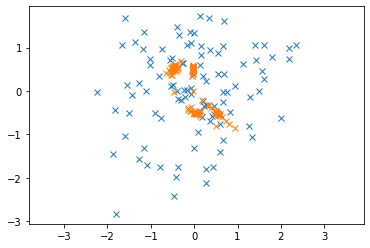

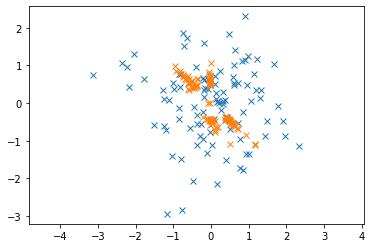

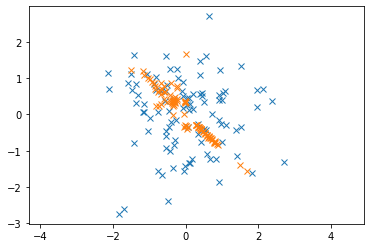

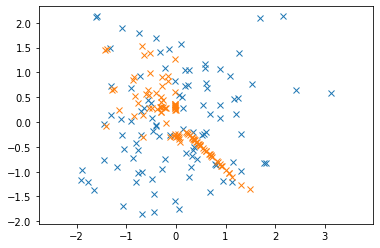

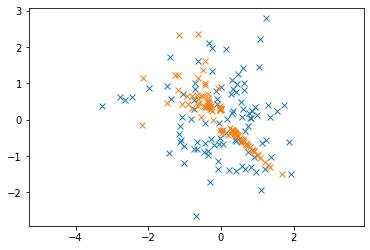

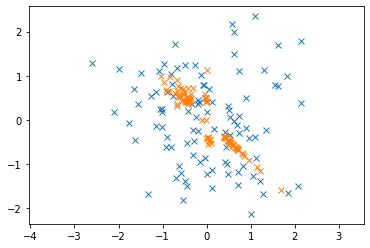

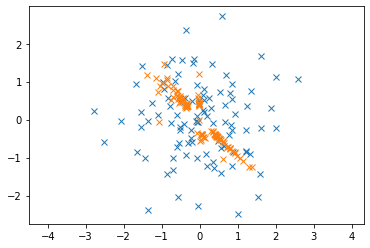

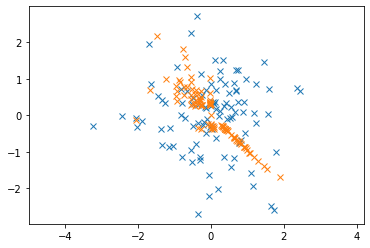

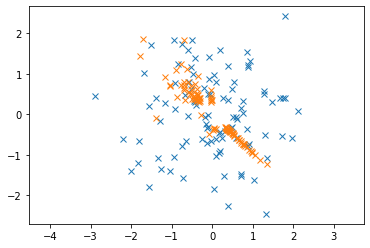

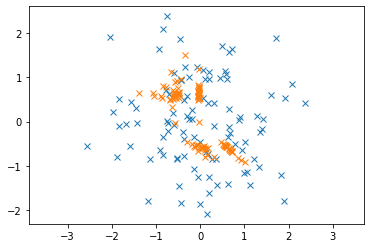

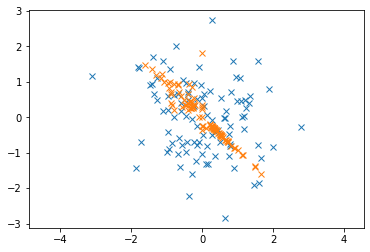

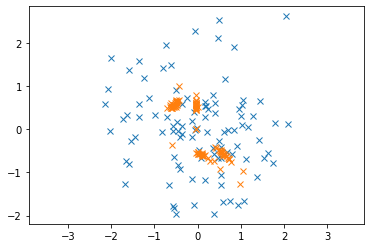

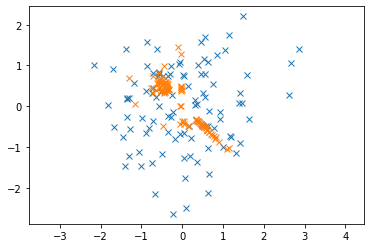

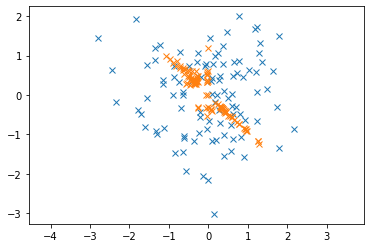

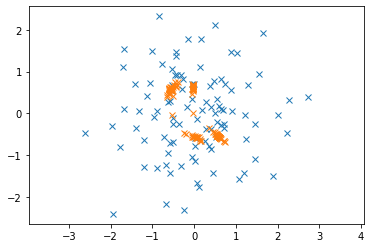

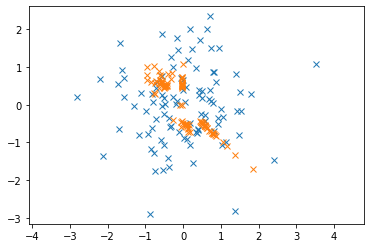

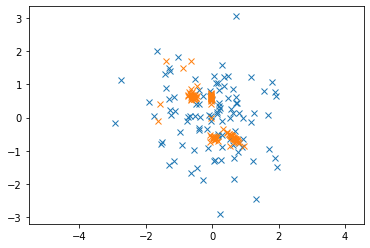

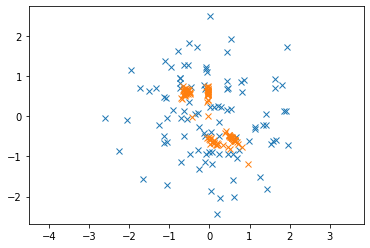

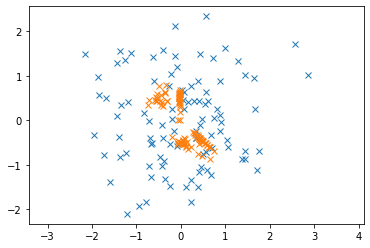

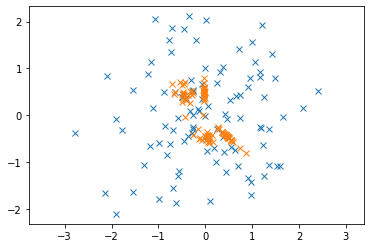

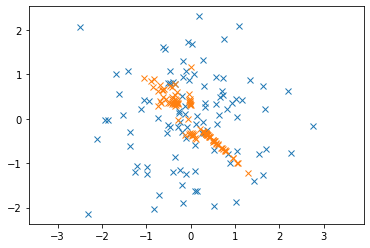

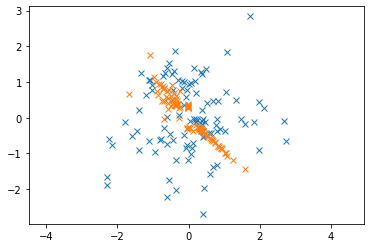

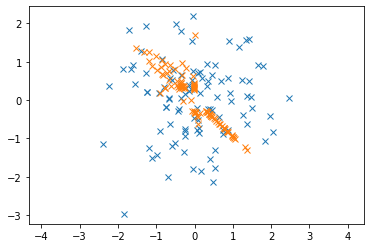

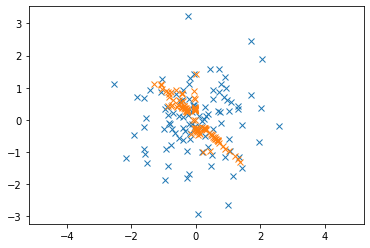

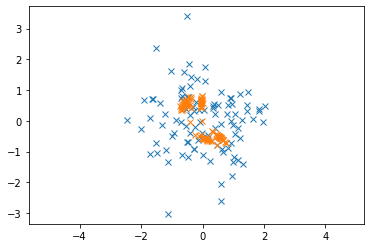

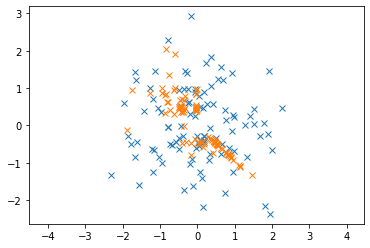

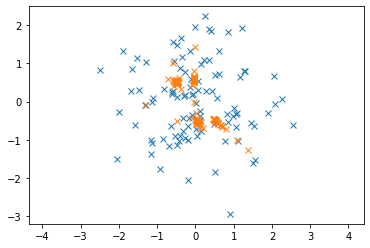

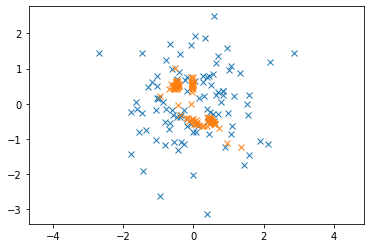

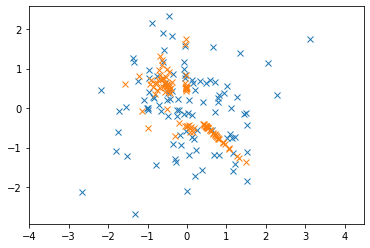

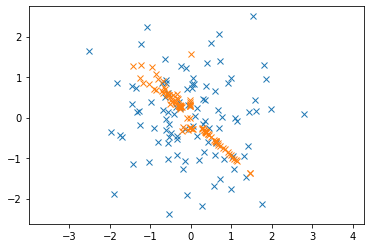

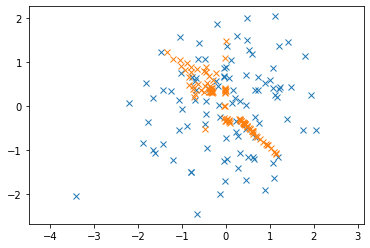

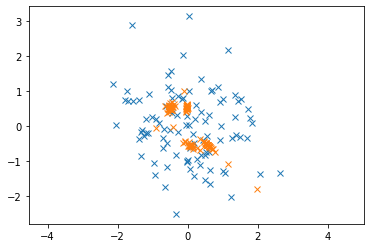

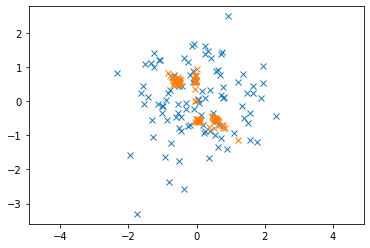

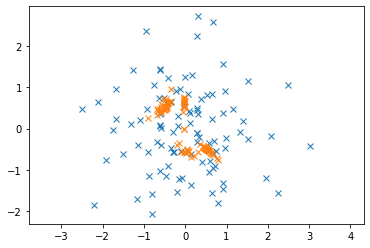

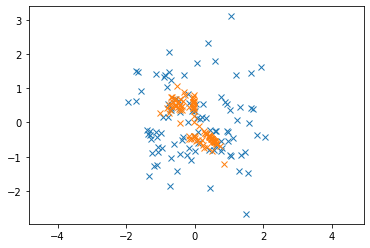

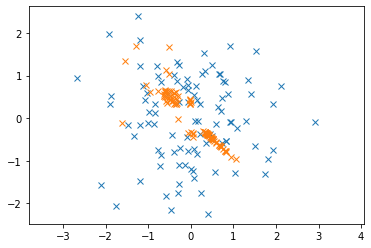

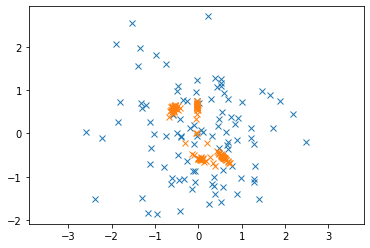

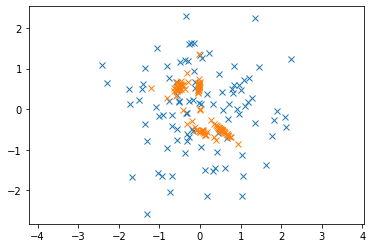

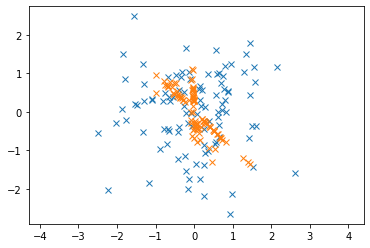

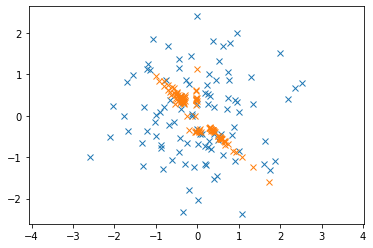

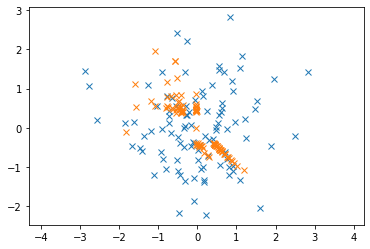

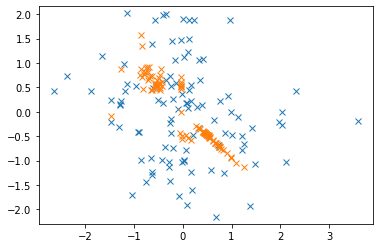

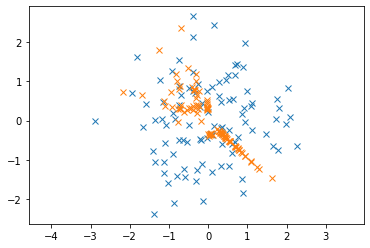

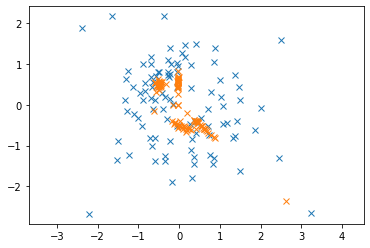

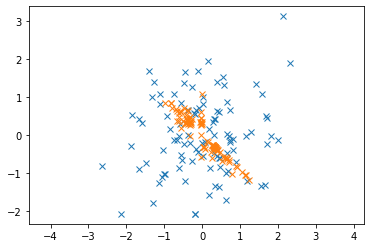

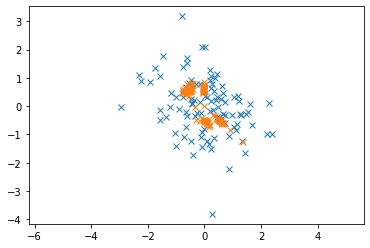

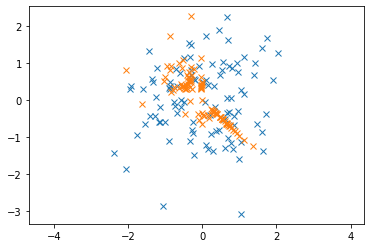

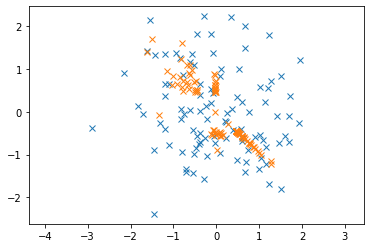

In [15]:
net.eval()
pred = net(test_data.view(n_test_data,1,200))
pred_data = pred.detach().cpu().numpy().reshape(n_test_data,-1,2)
x_pred = pred_data[:,:,0]
y_pred = pred_data[:,:,1]

for i in np.arange(0,1000,21):
    
    x_test, y_test = test_data[i].cpu().numpy().reshape(-1,2).T
    plt.plot(x_test, y_test, 'x')
    plt.plot(x_pred[i], y_pred[i], 'x')
    plt.axis('equal')
    plt.show()

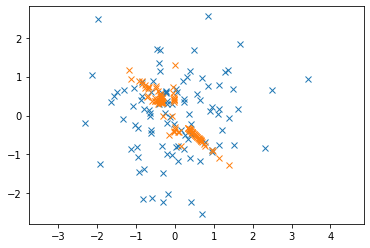

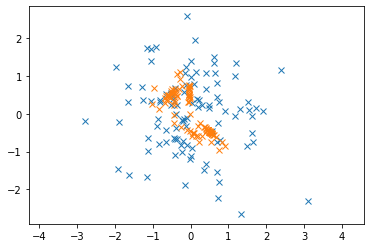

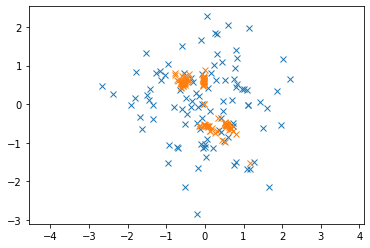

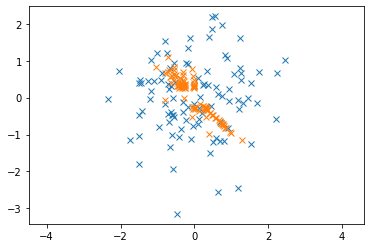

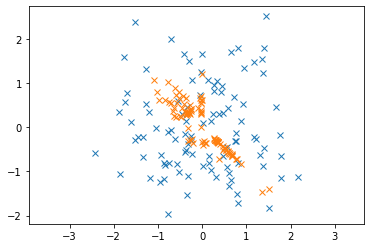

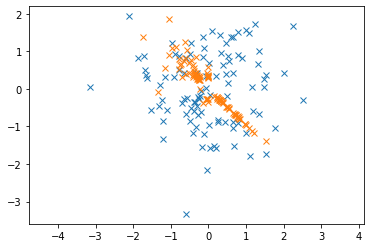

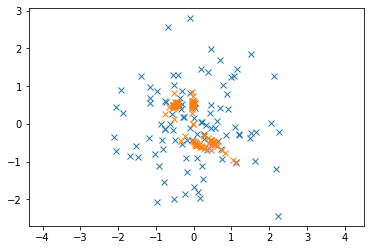

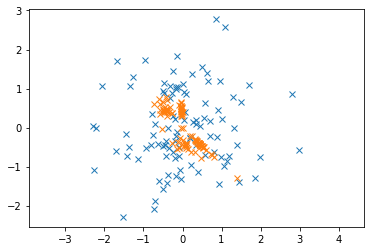

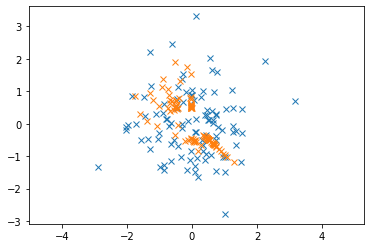

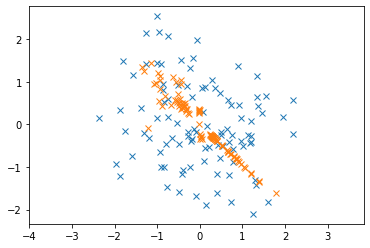

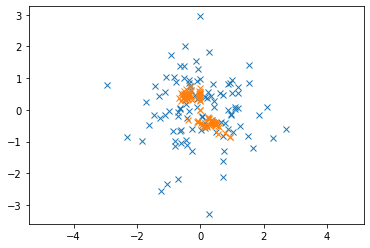

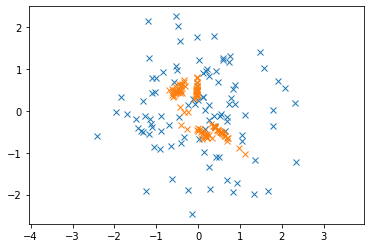

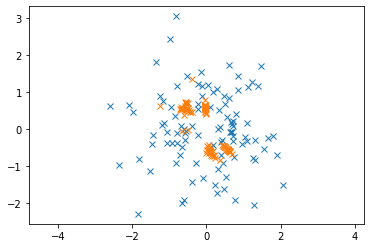

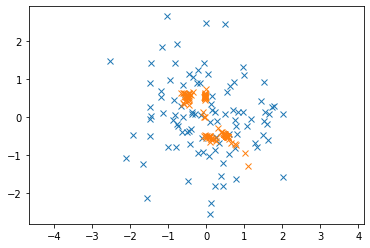

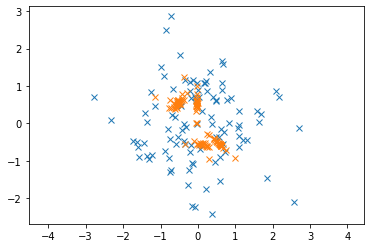

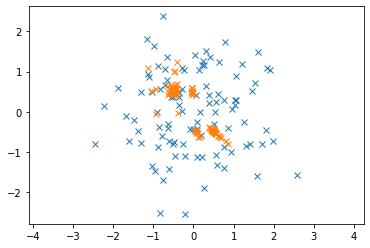

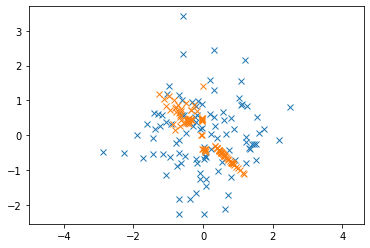

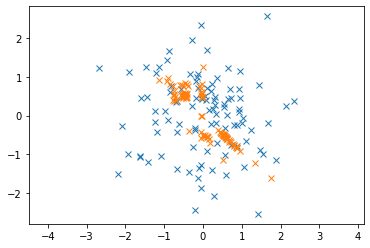

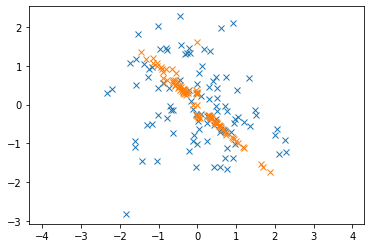

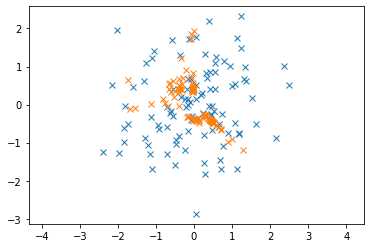

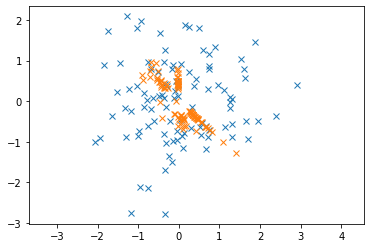

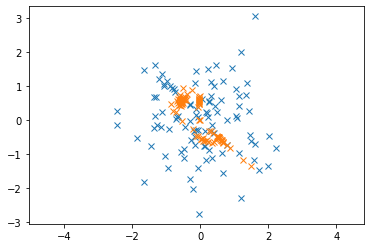

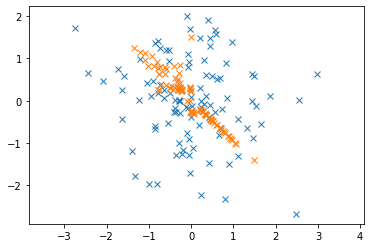

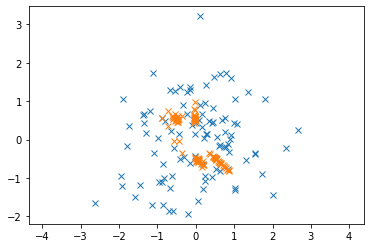

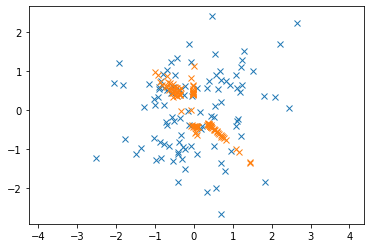

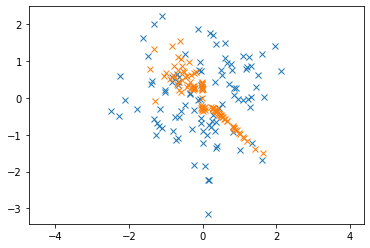

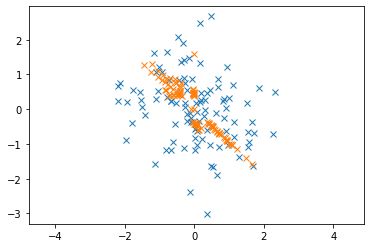

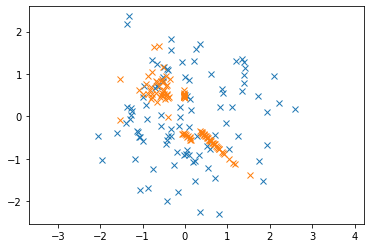

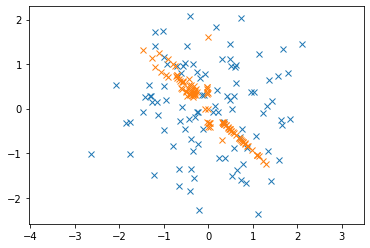

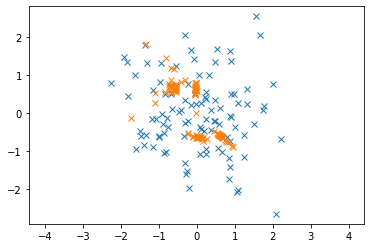

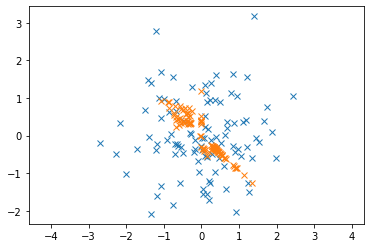

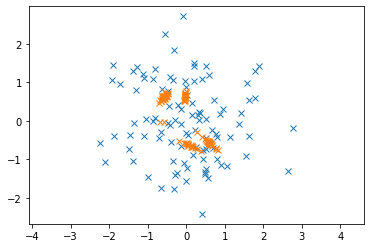

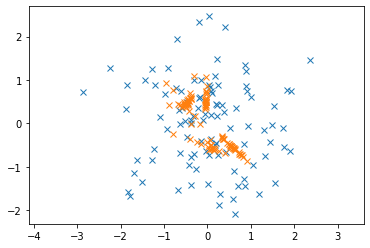

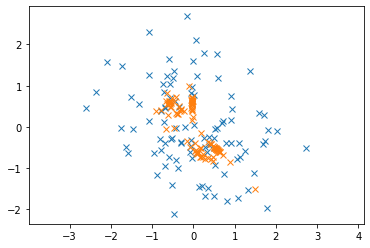

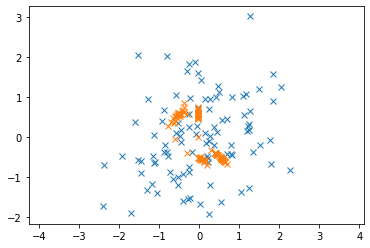

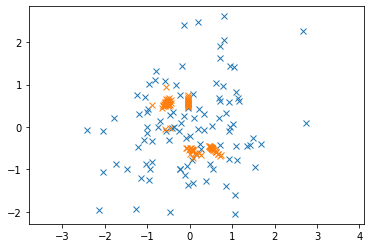

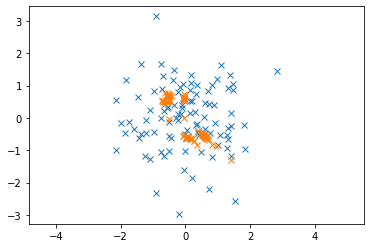

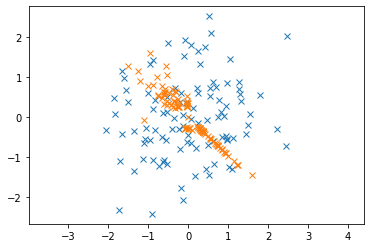

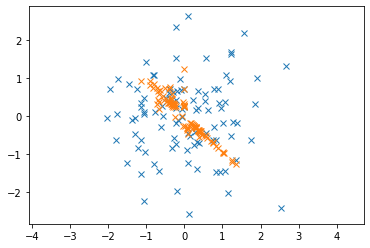

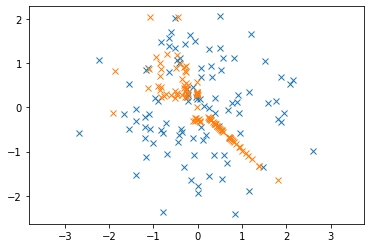

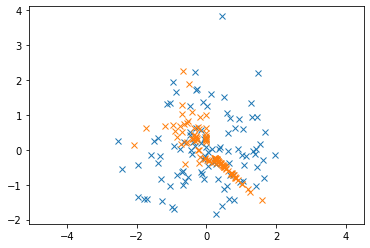

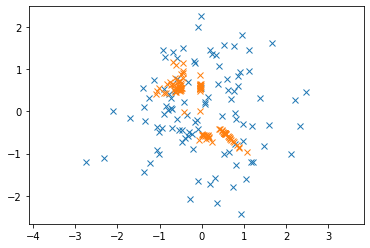

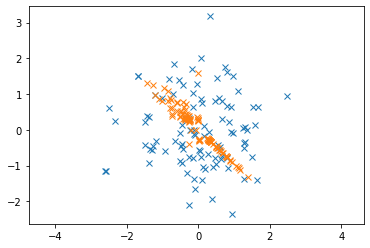

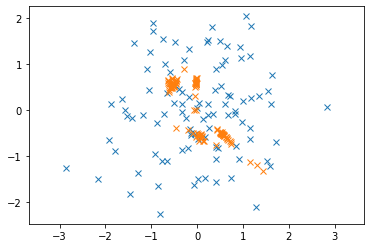

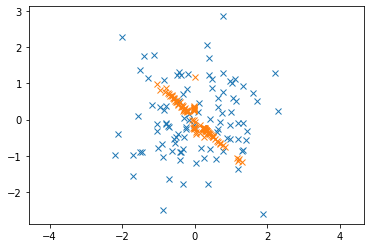

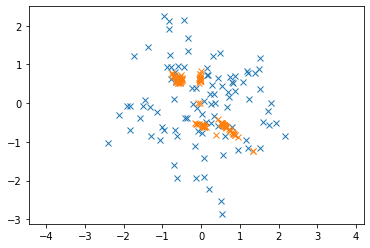

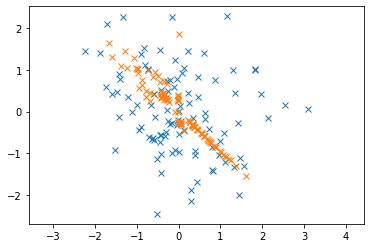

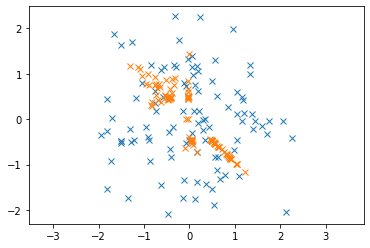

In [16]:
pred = net(train_data.view(n_train_data,1,200))
pred_data = pred.detach().cpu().numpy().reshape(n_train_data,-1,2)
x_pred = pred_data[:,:,0]
y_pred = pred_data[:,:,1]

for i in np.arange(0,1000,21):
    
    x_train, y_train = train_data[i].cpu().numpy().reshape(-1,2).T
    plt.plot(x_train, y_train, 'x')
    plt.plot(x_pred[i], y_pred[i], 'x')
    plt.axis('equal')
    plt.show()